## 1. 모델링

사전설정 (모델 훈련과 예측 모두 공통)

In [1]:
cols = ["KOSPI", "CR", "NASDAQ", "DOW", "NIKKEI", "SHANGHAI"]
len_x_ARMA = 10
len_y_nextday = 20

1-1) 데이터 크롤링

In [2]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=50, perPage=100)
crawler.crawlData(cols)
df_crawled = crawler.removeNan()
df_crawled


KOSPI : 50번째 페이지 데이터 수집중...
CR : 50번째 페이지 데이터 수집중...
NASDAQ : 50번째 페이지 데이터 수집중...
DOW : 50번째 페이지 데이터 수집중...
NIKKEI : 50번째 페이지 데이터 수집중...


,date,KOSPI,CR,NASDAQ,DOW,NIKKEI,SHANGHAI
0,2022-02-18,2744.52,1195.5,13548.066,34079.18,27122.07,286.366
1,2022-02-17,2744.09,1197.5,13716.719,34312.03,27232.87,284.743
2,2022-02-16,2729.68,1198.0,14124.095,34934.27,27460.40,284.624
3,2022-02-15,2676.54,1197.5,14139.757,34988.84,26865.19,283.019
4,2022-02-14,2704.48,1197.5,13790.919,34566.17,27079.59,283.258
...,...,...,...,...,...,...,...
2852,2010-07-26,1769.07,1190.0,2296.430,10525.43,9503.66,233.044
2853,2010-07-23,1758.06,1194.0,2269.470,10424.62,9430.96,231.191
2854,2010-07-22,1735.53,1202.0,2245.890,10322.30,9220.88,231.672
2855,2010-07-21,1748.78,1205.5,2187.330,10120.53,9278.83,229.873


1-2. 데이터 전처리

In [3]:
from kospi_predict import DataPreprocessor

dpp = DataPreprocessor(df_crawled, cols)
dpp.sortByDate()
dpp.scalingForModeling()
dpp.makeTargetXs(len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)
dpp.splitData()
dpp.df_cutoff

,date,KOSPI,CR,NASDAQ,DOW,NIKKEI,SHANGHAI,KOSPI_scaled,CR_scaled,NASDAQ_scaled,...,Y_KOSPI_scaled_nextday_11,Y_KOSPI_scaled_nextday_12,Y_KOSPI_scaled_nextday_13,Y_KOSPI_scaled_nextday_14,Y_KOSPI_scaled_nextday_15,Y_KOSPI_scaled_nextday_16,Y_KOSPI_scaled_nextday_17,Y_KOSPI_scaled_nextday_18,Y_KOSPI_scaled_nextday_19,Y_KOSPI_scaled_nextday_20
0,2010-08-04,1789.26,1171.0,2303.570,10680.43,9489.34,239.530,0.179490,0.599265,0.013594,...,0.174283,0.172064,0.167826,0.163940,0.150008,0.147285,0.147177,0.163723,0.154316,0.166191
1,2010-08-05,1783.86,1165.0,2293.060,10674.98,9653.92,239.970,0.176567,0.577206,0.012840,...,0.172064,0.167826,0.163940,0.150008,0.147285,0.147177,0.163723,0.154316,0.166191,0.172167
2,2010-08-06,1783.83,1164.0,2288.470,10653.56,9642.12,243.550,0.176551,0.573529,0.012511,...,0.167826,0.163940,0.150008,0.147285,0.147177,0.163723,0.154316,0.166191,0.172167,0.174489
3,2010-08-09,1790.17,1160.0,2305.690,10698.75,9572.49,246.592,0.179982,0.558824,0.013746,...,0.163940,0.150008,0.147285,0.147177,0.163723,0.154316,0.166191,0.172167,0.174489,0.181200
4,2010-08-10,1781.13,1169.0,2277.170,10644.25,9551.05,241.967,0.175089,0.591912,0.011700,...,0.150008,0.147285,0.147177,0.163723,0.154316,0.166191,0.172167,0.174489,0.181200,0.178667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,2022-01-12,2972.48,1192.5,15188.392,36290.32,28765.66,288.074,0.819909,0.678309,0.937673,...,0.626147,0.652587,0.676662,0.699632,0.696818,0.697581,0.709694,0.711361,0.698252,0.674854
2822,2022-01-13,2962.09,1185.5,14806.812,36113.62,28489.13,288.048,0.814286,0.652574,0.910307,...,0.652587,0.676662,0.699632,0.696818,0.697581,0.709694,0.711361,0.698252,0.674854,0.659731
2823,2022-01-14,2921.92,1188.0,14893.753,35911.81,28124.28,286.838,0.792544,0.661765,0.916542,...,0.676662,0.699632,0.696818,0.697581,0.709694,0.711361,0.698252,0.674854,0.659731,0.688494
2824,2022-01-17,2890.10,1192.5,14700.325,35640.14,28333.52,287.162,0.775321,0.678309,0.902670,...,0.699632,0.696818,0.697581,0.709694,0.711361,0.698252,0.674854,0.659731,0.688494,0.696293


1-3) 모델 훈련하고 생성

2022-02-22 15:03:33.900290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 15:03:33.900370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-22 15:03:33.988324: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 840)               101640    
                                                                 
 dense_1 (Dense)             (None, 840)               706440    
                                                                 
 dense_2 (Dense)             (None, 840)               706440    
                                                                 
 dense_3 (Dense)             (None, 840)               706440    
                                                                 
 dense_4 (Dense)             (None, 840)               706440    
                                             

2022-02-22 15:03:34.254629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 15:03:35.546715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


모델 생성 완료799/800(100%) loss : 0.0001, mae : 0.0071, mse : 0.0001 / val_loss : 0.0002, val_mae : 0.0109, val_mse : 0.0002                              
모델 저장 완료


2022-02-22 15:13:17.177915: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: kospi_predictor_model/saved_model/assets


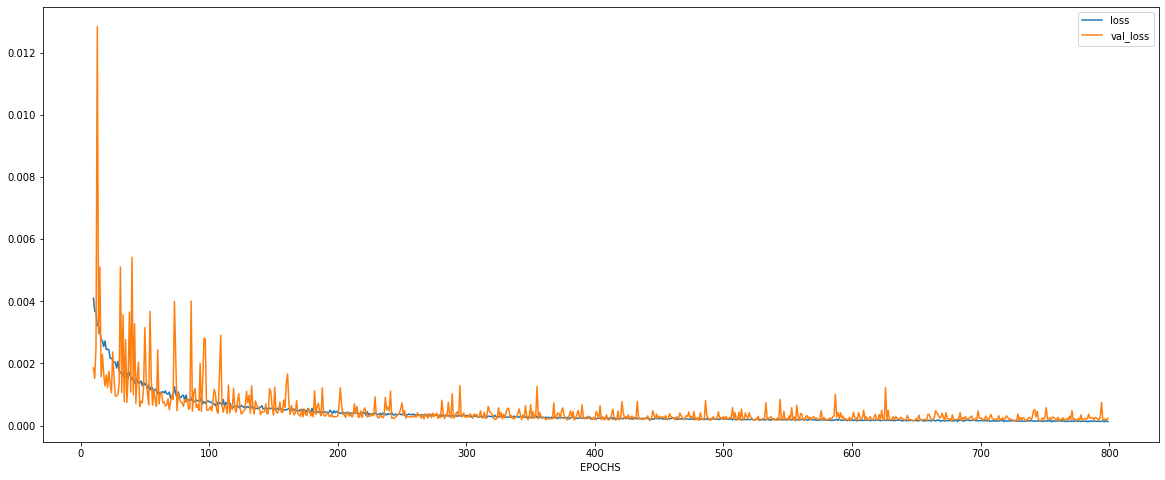

2022-02-22 15:13:17.928772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


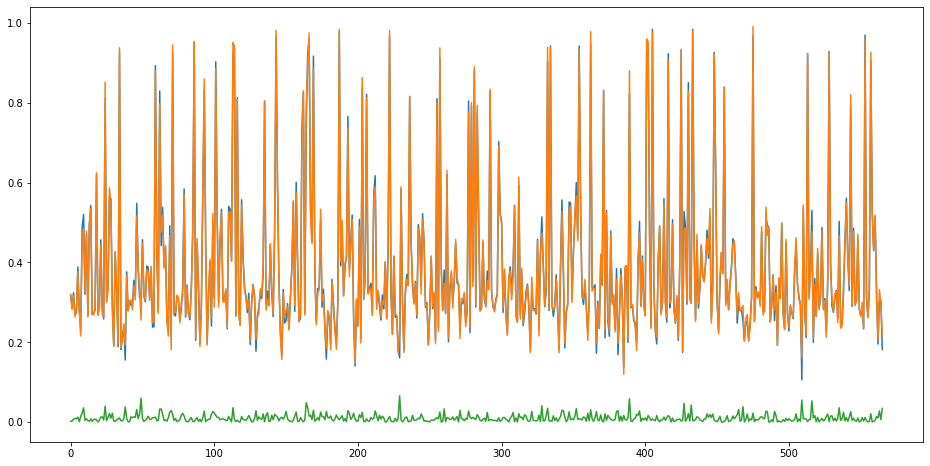

In [4]:
from kospi_predict import ModelMaker

maker = ModelMaker(dpp.y_list, dpp.df_train, dpp.df_test)
maker.makeModel(EPOCHS=800, history_plot_cutoff=30, learning_rate=0.0008)
maker.validateModel(y_no=0)

## 2. 최근 데이터로 20일 간의 KOSPI 지수 예측

2-1) 데이터 수집

In [5]:
from kospi_predict import Crawler

#예측을 위해서는 현재기준 이전 10일간의 데이터만 있으면 됨 (len_x_ARMA가 10일때)
crawler_pred = Crawler(crawl_page_max=1, perPage=50) #이전 추세도 볼겸 넉넉히 수집
crawler_pred.crawlData(cols)
df_crawled_pred = crawler_pred.removeNan()
df_crawled_pred


KOSPI : 1번째 페이지 데이터 수집중...
CR : 1번째 페이지 데이터 수집중...
NASDAQ : 1번째 페이지 데이터 수집중...
DOW : 1번째 페이지 데이터 수집중...
NIKKEI : 1번째 페이지 데이터 수집중...


,date,KOSPI,CR,NASDAQ,DOW,NIKKEI,SHANGHAI
0,2022-02-18,2744.52,1195.5,13548.066,34079.18,27122.070,286.366
1,2022-02-17,2744.09,1197.5,13716.719,34312.03,27232.870,284.743
2,2022-02-16,2729.68,1198.0,14124.095,34934.27,27460.400,284.624
3,2022-02-15,2676.54,1197.5,14139.757,34988.84,26865.190,283.019
4,2022-02-14,2704.48,1197.5,13790.919,34566.17,27079.590,283.258
5,2022-02-11,2747.71,1197.0,13791.154,34738.06,27387.835,285.216
6,2022-02-10,2771.93,1196.5,14185.641,35241.59,27696.080,285.679
7,2022-02-09,2768.85,1196.0,14490.373,35768.06,27579.870,285.237
8,2022-02-08,2746.47,1198.5,14194.455,35462.78,27284.520,282.772
9,2022-02-07,2745.06,1200.5,14015.668,35091.13,27248.870,282.482


2-2) 데이터 전처리

In [6]:
from kospi_predict import DataPreprocessor

#아래는 예측을 위한 전처리
dpp_pred = DataPreprocessor(df_crawled_pred, cols)
dpp_pred.sortByDate()
dpp_pred.scalingForPredict()
dpp_pred.makeTargetXs(len_x_ARMA)
dpp_pred.cutoffData(len_x_ARMA, 0)

2-3) 예측

2022-02-22 15:13:19.808802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


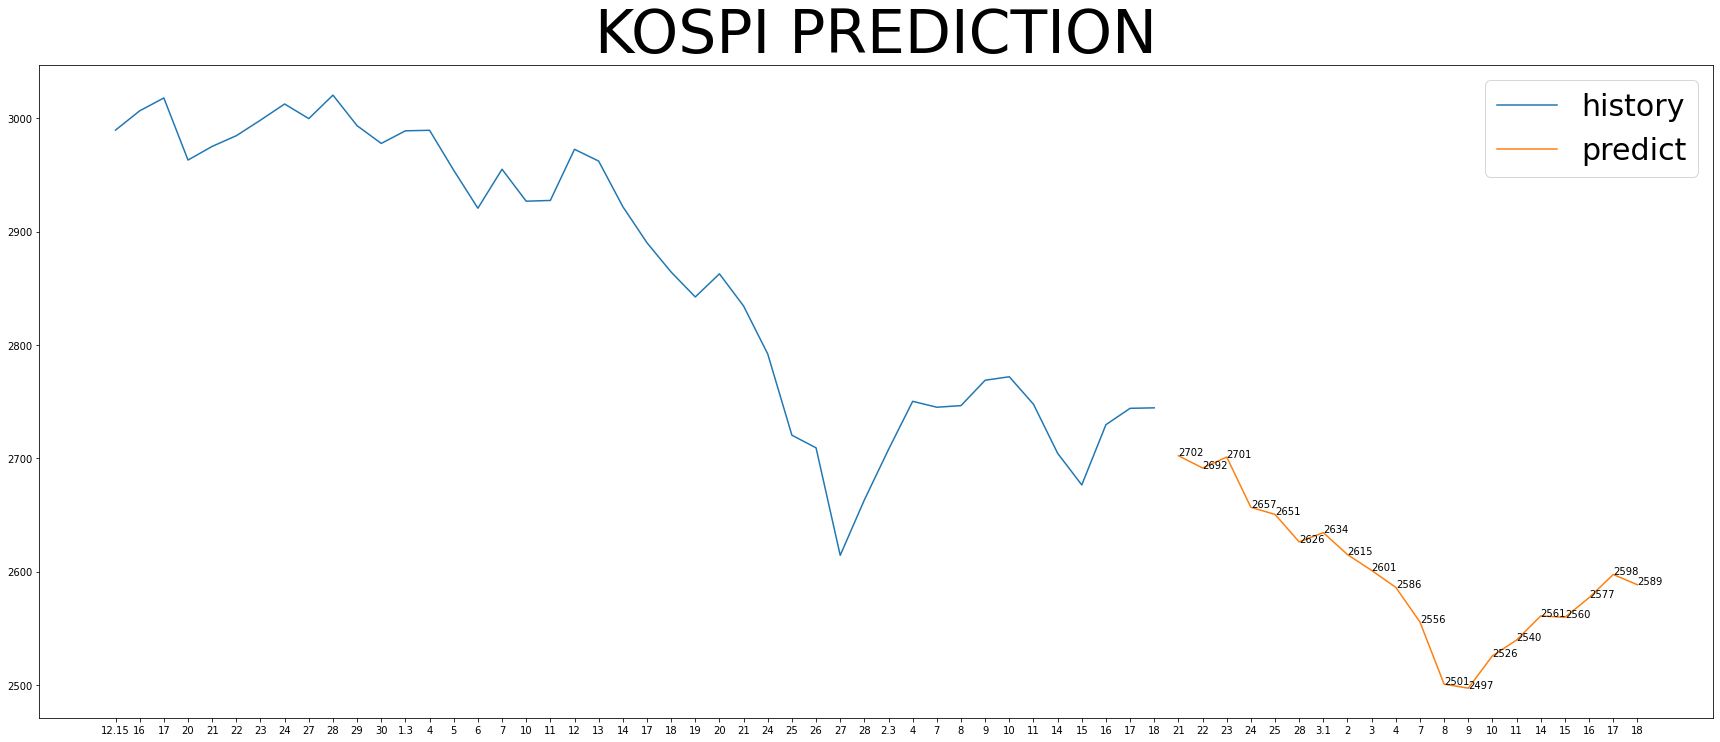

In [7]:
from kospi_predict import Predictor

#2.18 기준으로 20일 뒤까지 예측하고 시각화

predictor = Predictor(dpp_pred.df)
predictor.predict()
predictor.showPredictionPlot()
# predictor.saveModelToJS()

In [8]:

predictor.saveModelToJS()